In [1]:
from pyspark.sql import SparkSession
spark = (
    SparkSession 
    .builder 
    .appName("Streaming from Kafka") 
    .config("spark.streaming.stopGracefullyOnShutdown", True)
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0,com.datastax.spark:spark-cassandra-connector_2.12:3.5.0")
    .config("spark.cassandra.connection.host", "127.0.0.1")
    .config("spark.executor.memory", "4g")
    .config("spark.driver.memory", "2g")
    .config("spark.cassandra.auth.username", "cassandra")
    .config("spark.cassandra.auth.password", "cassandra")
    .master("local[*]") 
    .getOrCreate()
)

25/01/20 21:47:36 WARN Utils: Your hostname, Ala resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/01/20 21:47:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ala/.ivy2/cache
The jars for the packages stored in: /home/ala/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d1adb810-101d-48cf-8e74-df1a8b36b04c;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.0 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.3 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.commons#commons-pool2;2.11.1 in cent

In [2]:
df = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .option("keyspace", "test") \
    .option("table", "vehicle_data_st") \
    .load()


In [4]:
df.count()

121

In [8]:
unique_trip_ids_count = df.select("trip_id").distinct().count()

# Afficher le résultat
print(f"Nombre de trip_id uniques : {unique_trip_ids_count}")

Nombre de trip_id uniques : 9


In [5]:
from pyspark.sql import functions as F

# Trier les données par type de véhicule et heure d'arrivée
df_sorted = df.orderBy("vehicle_type", "arrival_time")

# Récupérer les données collectées
vehicle_groups = df_sorted.groupBy("vehicle_type").agg(F.collect_list(F.struct("trip_id", "tst", "arrival_time", "departure_time", "nextStop")).alias("vehicle_data"))

# Construire les arêtes par véhicule
edges = []
for row in vehicle_groups.collect():
    vehicle_data = row["vehicle_data"]
    vehicle_id = row["vehicle_type"]
    
    for i in range(len(vehicle_data) - 1):
        row_current = vehicle_data[i]
        row_next = vehicle_data[i + 1]

        # S'assurer que l'arrêt suivant est bien dans l'ordre
        if row_next["arrival_time"] > row_current["departure_time"]:
            source = f"Station {row_current['nextStop']}"
            target = f"Station {row_next['nextStop']}"

            # Calculer le temps entre les deux stations (en minutes)
            travel_time = (row_next["arrival_time"] - row_current["departure_time"]).total_seconds() / 60

            # Ajouter une arête avec source, target, poids et identifiant du véhicule
            edges.append((source, target, travel_time, vehicle_id))

# Afficher les arêtes
print("Arêtes (edges) :")
for edge in edges:
    print(edge)


Arêtes (edges) :
('Station 1382178', 'Station 1040144', 23.316666666666666, 'bus')
('Station 1130103', 'Station 4950202', 16.933333333333334, 'bus')
('Station 1171405', 'Station 1220406', 2.966666666666667, 'tram')
('Station 1240418', 'Station 2112401', 13.366666666666667, 'tram')
('Station 9090501', 'Station 1370501', 14.516666666666667, 'train')
('Station 1392501', 'Station 1020503', 14.833333333333334, 'train')


In [6]:
import networkx as nx
import matplotlib.pyplot as plt

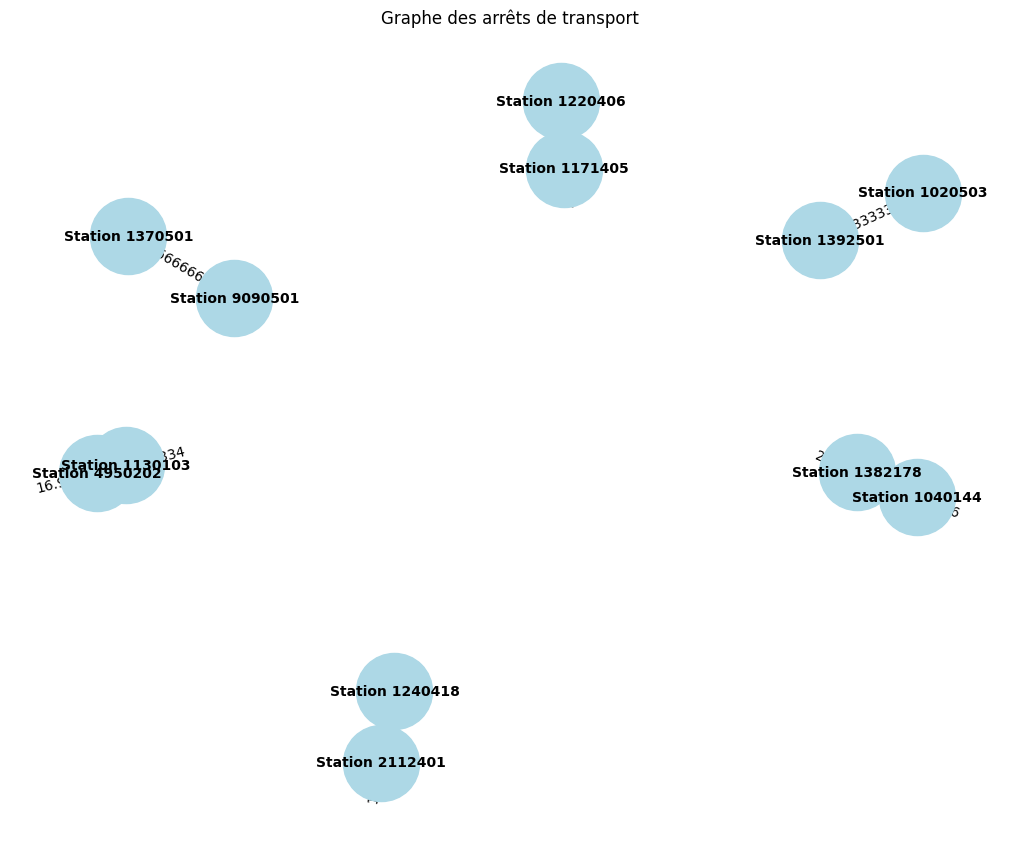

In [7]:
G = nx.DiGraph()

# Ajouter des arêtes au graphe
for source, target, weight, vehicle_id in edges:
    G.add_edge(source, target, weight=weight, vehicle_type=vehicle_id)

# Définir les positions pour les nœuds dans le graphique
pos = nx.spring_layout(G)  # Utilise une disposition spring pour les nœuds

# Dessiner le graphe
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", arrows=True)

# Afficher les étiquettes des arêtes (poids)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Afficher le graphique
plt.title("Graphe des arrêts de transport")
plt.show()

In [10]:
import networkx as nx
import pandas as pd
from datetime import datetime

In [17]:
df.show()

+--------------------+--------------------+-------------------+-------------------+----+----+---------+---------+--------+--------+-----+----------+----------+------------+
|             trip_id|                 tst|       arrival_time|     departure_time|desi|  dl|      lat|     long|nextstop|route_id|  spd|start_date|start_time|vehicle_type|
+--------------------+--------------------+-------------------+-------------------+----+----+---------+---------+--------+--------+-----+----------+----------+------------+
|4570_2025-01-20_2...|2025-01-20T20:40:...|2025-01-20 22:20:56|2025-01-20 22:21:40| 570|-284|60.250085|25.094743| 4950202|    4570|11.99|2025-01-20|  22:30:00|         bus|
|4570_2025-01-20_2...|2025-01-20T20:40:...|2025-01-20 22:20:56|2025-01-20 22:21:40| 570|-284|60.250105|25.094523| 4950202|    4570|12.55|2025-01-20|  22:30:00|         bus|
|4570_2025-01-20_2...|2025-01-20T20:40:...|2025-01-20 22:20:56|2025-01-20 22:21:40| 570|-284|60.250128|25.094292| 4950202|    4570|12.9

In [18]:
G = nx.DiGraph()

# Ajouter les nœuds et les arêtes
prev_row = None  # Variable pour stocker la ligne précédente
for row in df:
    node_id = row['nextstop']
    G.add_node(node_id, lat=row['lat'], long=row['long'], vehicle_type=row['vehicle_type'])
    
    # Ajouter des arêtes entre les arrêts successifs pour le même trip_id
    if prev_row is not None and prev_row['trip_id'] == row['trip_id']:
        G.add_edge(prev_row['nextstop'], node_id, spd=row['spd'], tst=row['tst'])
    
    prev_row = row  # Stocker la ligne précédente pour la comparaison

# Visualiser le graphe
pos = {node: (data['long'], data['lat']) for node, data in G.nodes(data=True)}
nx.draw(G, pos, with_labels=True, node_size=50, font_size=8)
plt.show()

# Détection des retards
for node, data in G.nodes(data=True):
    if 'arrival_time' in data:
        arrival_time = datetime.fromisoformat(data['arrival_time'])
        tst = datetime.fromisoformat(data['tst'])
        if tst > arrival_time:
            print(f"Retard détecté à l'arrêt {node}: {tst - arrival_time}")

TypeError: unhashable type: 'Column'